# Import Necessary Libraries and Data

In [163]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, classification_report
from sklearn import tree
from imblearn.over_sampling import SMOTE
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

In [164]:
training_labels = pd.read_csv('Data/training_set_labels.csv', index_col='respondent_id')
training_features = pd.read_csv('Data/training_set_features.csv', index_col='respondent_id')

# Explore the Data

In [165]:
training_labels.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 26707 entries, 0 to 26706
Data columns (total 2 columns):
 #   Column            Non-Null Count  Dtype
---  ------            --------------  -----
 0   h1n1_vaccine      26707 non-null  int64
 1   seasonal_vaccine  26707 non-null  int64
dtypes: int64(2)
memory usage: 625.9 KB


In [166]:
training_labels.h1n1_vaccine.value_counts()

0    21033
1     5674
Name: h1n1_vaccine, dtype: int64

** Note this class imbalance for later. **

In [167]:
training_features.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 26707 entries, 0 to 26706
Data columns (total 35 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   h1n1_concern                 26615 non-null  float64
 1   h1n1_knowledge               26591 non-null  float64
 2   behavioral_antiviral_meds    26636 non-null  float64
 3   behavioral_avoidance         26499 non-null  float64
 4   behavioral_face_mask         26688 non-null  float64
 5   behavioral_wash_hands        26665 non-null  float64
 6   behavioral_large_gatherings  26620 non-null  float64
 7   behavioral_outside_home      26625 non-null  float64
 8   behavioral_touch_face        26579 non-null  float64
 9   doctor_recc_h1n1             24547 non-null  float64
 10  doctor_recc_seasonal         24547 non-null  float64
 11  chronic_med_condition        25736 non-null  float64
 12  child_under_6_months         25887 non-null  float64
 13  health_worker   

In [168]:
# Create one DataFrame to house all of our data
data_df = pd.concat([training_features, training_labels], axis=1)

In [169]:
data_df.head()

,h1n1_concern,h1n1_knowledge,behavioral_antiviral_meds,behavioral_avoidance,behavioral_face_mask,behavioral_wash_hands,behavioral_large_gatherings,behavioral_outside_home,behavioral_touch_face,doctor_recc_h1n1,...,rent_or_own,employment_status,hhs_geo_region,census_msa,household_adults,household_children,employment_industry,employment_occupation,h1n1_vaccine,seasonal_vaccine
respondent_id,,,,,,,,,,,,,,,,,,,,,
0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,...,Own,Not in Labor Force,oxchjgsf,Non-MSA,0.0,0.0,NaN,NaN,0,0
1,3.0,2.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,...,Rent,Employed,bhuqouqj,"MSA, Not Principle City",0.0,0.0,pxcmvdjn,xgwztkwe,0,1
2,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,NaN,...,Own,Employed,qufhixun,"MSA, Not Principle City",2.0,0.0,rucpziij,xtkaffoo,0,0
3,1.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,...,Rent,Not in Labor Force,lrircsnp,"MSA, Principle City",0.0,0.0,NaN,NaN,0,1
4,2.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,...,Own,Employed,qufhixun,"MSA, Not Principle City",1.0,0.0,wxleyezf,emcorrxb,0,0


# Clean the Data

## Remove Unnecessary Columns

The columns that we are removing either have to do with the Seasonal Vaccine, or have too much missing data.

In [170]:
h1n1_df = data_df.drop(['health_insurance',
                              'opinion_seas_vacc_effective',
                              'opinion_seas_risk',
                              'opinion_seas_sick_from_vacc',
                              'doctor_recc_seasonal',
                              'employment_industry',
                              'employment_occupation',
                              'seasonal_vaccine'], axis=1)
h1n1_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 26707 entries, 0 to 26706
Data columns (total 29 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   h1n1_concern                 26615 non-null  float64
 1   h1n1_knowledge               26591 non-null  float64
 2   behavioral_antiviral_meds    26636 non-null  float64
 3   behavioral_avoidance         26499 non-null  float64
 4   behavioral_face_mask         26688 non-null  float64
 5   behavioral_wash_hands        26665 non-null  float64
 6   behavioral_large_gatherings  26620 non-null  float64
 7   behavioral_outside_home      26625 non-null  float64
 8   behavioral_touch_face        26579 non-null  float64
 9   doctor_recc_h1n1             24547 non-null  float64
 10  chronic_med_condition        25736 non-null  float64
 11  child_under_6_months         25887 non-null  float64
 12  health_worker                25903 non-null  float64
 13  opinion_h1n1_vac

## Dealing with Missing Data

In [171]:
# Check for missing data
print('Missing Data: \n',h1n1_df.isna().sum())

Missing Data: 
 h1n1_concern                     92
h1n1_knowledge                  116
behavioral_antiviral_meds        71
behavioral_avoidance            208
behavioral_face_mask             19
behavioral_wash_hands            42
behavioral_large_gatherings      87
behavioral_outside_home          82
behavioral_touch_face           128
doctor_recc_h1n1               2160
chronic_med_condition           971
child_under_6_months            820
health_worker                   804
opinion_h1n1_vacc_effective     391
opinion_h1n1_risk               388
opinion_h1n1_sick_from_vacc     395
age_group                         0
education                      1407
race                              0
sex                               0
income_poverty                 4423
marital_status                 1408
rent_or_own                    2042
employment_status              1463
hhs_geo_region                    0
census_msa                        0
household_adults                249
household_ch

We will want to create a new value for columns missing between 5 and 10 percent of the data.  If the column is missing less than 5 percent of data values, we will drop those values.

In [172]:
print('5% of data:', round(26707*.05, 2))
print('10% of data:', round(26707*.1, 2))

5% of data: 1335.35
10% of data: 2670.7


Create a new category "unknown" for the columns with 1000+ missing entries.
Drop rows if the column is missing less than 1000 entries.
Columns to adjust: doctor_recc_h1n1, education, income_poverty, marital_status, rent_or_own, employment_status.

In [173]:
# Since doctor recc h1n1 is already a float, we will create a numeric value, .5, to stand in for our unknown category
h1n1_df['doctor_recc_h1n1'].fillna(value=.5, inplace=True)

In [174]:
# Create an unknown category for missing data
need_new_category = ['education', 
                     'income_poverty', 
                     'marital_status', 
                     'rent_or_own', 
                     'employment_status']
for column in need_new_category:
    h1n1_df[column].fillna(value='unknown', inplace=True)

In [175]:
# Check our remaining null values
h1n1_df.isna().sum()

h1n1_concern                    92
h1n1_knowledge                 116
behavioral_antiviral_meds       71
behavioral_avoidance           208
behavioral_face_mask            19
behavioral_wash_hands           42
behavioral_large_gatherings     87
behavioral_outside_home         82
behavioral_touch_face          128
doctor_recc_h1n1                 0
chronic_med_condition          971
child_under_6_months           820
health_worker                  804
opinion_h1n1_vacc_effective    391
opinion_h1n1_risk              388
opinion_h1n1_sick_from_vacc    395
age_group                        0
education                        0
race                             0
sex                              0
income_poverty                   0
marital_status                   0
rent_or_own                      0
employment_status                0
hhs_geo_region                   0
census_msa                       0
household_adults               249
household_children             249
h1n1_vaccine        

In [176]:
# Drop the remaining null values from the dataset
h1n1_df.dropna(inplace=True)
h1n1_df.isna().sum()

h1n1_concern                   0
h1n1_knowledge                 0
behavioral_antiviral_meds      0
behavioral_avoidance           0
behavioral_face_mask           0
behavioral_wash_hands          0
behavioral_large_gatherings    0
behavioral_outside_home        0
behavioral_touch_face          0
doctor_recc_h1n1               0
chronic_med_condition          0
child_under_6_months           0
health_worker                  0
opinion_h1n1_vacc_effective    0
opinion_h1n1_risk              0
opinion_h1n1_sick_from_vacc    0
age_group                      0
education                      0
race                           0
sex                            0
income_poverty                 0
marital_status                 0
rent_or_own                    0
employment_status              0
hhs_geo_region                 0
census_msa                     0
household_adults               0
household_children             0
h1n1_vaccine                   0
dtype: int64

## Split our Data

Now that we have taken care of our null values, we can split our data into features and labels for our train test split.

In [177]:
# Create features and labels
h1n1_features = h1n1_df.drop('h1n1_vaccine', axis=1)
h1n1_labels = h1n1_df['h1n1_vaccine']

In [178]:
# Perform a train test split
X_train, X_test, y_train, y_test = train_test_split(h1n1_features,
                                                   h1n1_labels,
                                                   test_size=.25,
                                                   random_state=42)

## Encoding Categorical Columns

Before we can use this data to create models, we need all of our data values to be numeric.  We will use a OneHotEncoder to achieve this.

In [179]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 18621 entries, 18434 to 25446
Data columns (total 28 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   h1n1_concern                 18621 non-null  float64
 1   h1n1_knowledge               18621 non-null  float64
 2   behavioral_antiviral_meds    18621 non-null  float64
 3   behavioral_avoidance         18621 non-null  float64
 4   behavioral_face_mask         18621 non-null  float64
 5   behavioral_wash_hands        18621 non-null  float64
 6   behavioral_large_gatherings  18621 non-null  float64
 7   behavioral_outside_home      18621 non-null  float64
 8   behavioral_touch_face        18621 non-null  float64
 9   doctor_recc_h1n1             18621 non-null  float64
 10  chronic_med_condition        18621 non-null  float64
 11  child_under_6_months         18621 non-null  float64
 12  health_worker                18621 non-null  float64
 13  opinion_h1n1

In [180]:
categoricals = ['age_group',
               'education',
               'sex',
               'income_poverty',
               'marital_status',
               'rent_or_own',
               'employment_status',
               'hhs_geo_region',
               'census_msa',
               'race']

In [181]:
ohe = OneHotEncoder()
ohe.fit(X_train[categoricals])
X_train_ohe = ohe.transform(X_train[categoricals]).toarray()
X_train_ohe_df = pd.DataFrame(X_train_ohe, columns = ohe.get_feature_names(categoricals), index = X_train.index)

In [182]:
X_train.drop(categoricals, axis=1, inplace=True)
X_train_final = pd.concat([X_train_ohe_df, X_train], axis=1)

In [183]:
X_train_final.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 18621 entries, 18434 to 25446
Data columns (total 61 columns):
 #   Column                                    Non-Null Count  Dtype  
---  ------                                    --------------  -----  
 0   age_group_18 - 34 Years                   18621 non-null  float64
 1   age_group_35 - 44 Years                   18621 non-null  float64
 2   age_group_45 - 54 Years                   18621 non-null  float64
 3   age_group_55 - 64 Years                   18621 non-null  float64
 4   age_group_65+ Years                       18621 non-null  float64
 5   education_12 Years                        18621 non-null  float64
 6   education_< 12 Years                      18621 non-null  float64
 7   education_College Graduate                18621 non-null  float64
 8   education_Some College                    18621 non-null  float64
 9   education_unknown                         18621 non-null  float64
 10  sex_Female                    

In [184]:
X_train_final.rename(columns = {'age_group_18 - 34 Years' : 'age_group_18_34',
                            'age_group_35 - 44 Years' : 'age_group_35_44',
                            'age_group_45 - 54 Years' : 'age_group_45_54',
                            'age_group_55 - 64 Years' : 'age_group_55_64',
                            'age_group_65+ Years' : 'age_group_over_65',
                            'education_12 Years' : 'education_12_years',
                            'education_< 12 Years' : 'education_less_than_12',
                            'education_College Graduate' : 'education_college_grad',
                            'education_Some College': 'education_some_college',
                            'race_Other or Multiple' : 'race_other',
                            'income_poverty_<= $75,000, Above Poverty' : 'income_poverty_lessorequal_75k',
                            'income_poverty_> $75,000' : 'income_poverty_morethan_75k',
                            'income_poverty_Below Poverty' : 'income_poverty_below_poverty',
                            'marital_status_Not Married': 'marital_status_Unmarried',
                            'employment_status_Not in Labor Force' : 'employment_status_not_in_labor_force',
                            'census_msa_MSA, Not Principle  City' : 'census_msa_not_in_principle',
                            'census_msa_MSA, Principle City' : 'census_msa_in_principle',
                            'census_msa_Non-MSA' : 'census_msa_non_msa'},
                 inplace=True)

In [185]:
X_test_ohe = ohe.transform(X_test[categoricals]).toarray()
X_test_ohe_df = pd.DataFrame(X_test_ohe, columns = ohe.get_feature_names(categoricals), index = X_test.index)

In [186]:
X_test.drop(categoricals, axis=1, inplace=True)
X_test_final = pd.concat([X_test_ohe_df, X_test], axis=1)

In [187]:
X_test_final.rename(columns = {'age_group_18 - 34 Years' : 'age_group_18_34',
                            'age_group_35 - 44 Years' : 'age_group_35_44',
                            'age_group_45 - 54 Years' : 'age_group_45_54',
                            'age_group_55 - 64 Years' : 'age_group_55_64',
                            'age_group_65+ Years' : 'age_group_over_65',
                            'education_12 Years' : 'education_12_years',
                            'education_< 12 Years' : 'education_less_than_12',
                            'education_College Graduate' : 'education_college_grad',
                            'education_Some College': 'education_some_college',
                            'race_Other or Multiple' : 'race_other',
                            'income_poverty_<= $75,000, Above Poverty' : 'income_poverty_lessorequal_75k',
                            'income_poverty_> $75,000' : 'income_poverty_morethan_75k',
                            'income_poverty_Below Poverty' : 'income_poverty_below_poverty',
                            'marital_status_Not Married': 'marital_status_Unmarried',
                            'employment_status_Not in Labor Force' : 'employment_status_not_in_labor_force',
                            'census_msa_MSA, Not Principle  City' : 'census_msa_not_in_principle',
                            'census_msa_MSA, Principle City' : 'census_msa_in_principle',
                            'census_msa_Non-MSA' : 'census_msa_non_msa'},
                 inplace=True)

## Class Imbalance

As we noted earlier, this dataset has a significant class imbalance.  In order to get the best model results, we will use SMOTE to adjust our training dataset.

In [188]:
y_train.value_counts()

0    14615
1     4006
Name: h1n1_vaccine, dtype: int64

In [189]:
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_sample(X_train_final, y_train)

In [190]:
y_train_resampled.value_counts()

1    14615
0    14615
Name: h1n1_vaccine, dtype: int64

Now that our data is cleaned, we will begin making models.

# Models

For our baseline model, we will use a decision stump.  After finding our baseline scores, we will then move on to more advanced models to improve our scores.

## Baseline Model

In [191]:
# Create a basic decision stump model
clf = DecisionTreeClassifier(random_state=42, max_depth=3)
clf.fit(X_train_resampled, y_train_resampled)

DecisionTreeClassifier(max_depth=3, random_state=42)

In [200]:
print('Decision Stump Model Training Scores: \n', 
      classification_report(y_train_resampled, clf.predict(X_train_resampled)))
print('Decision Stump Model Test Scores: \n', 
      classification_report(y_test, clf.predict(X_test_final)))

Decision Stump Model Training Scores: 
               precision    recall  f1-score   support

           0       0.72      0.79      0.75     14615
           1       0.77      0.70      0.73     14615

    accuracy                           0.74     29230
   macro avg       0.75      0.74      0.74     29230
weighted avg       0.75      0.74      0.74     29230

Decision Stump Model Test Scores: 
               precision    recall  f1-score   support

           0       0.87      0.79      0.83      4898
           1       0.42      0.55      0.47      1309

    accuracy                           0.74      6207
   macro avg       0.64      0.67      0.65      6207
weighted avg       0.77      0.74      0.75      6207



## Tuned Decision Tree

In [195]:
param_grid = {'criterion': ['gini', 'entropy'],
             'max_depth' : [1, 2, 5, 10],
             'min_samples_split' : [2, 3, 10, 20]}

gs_tree = GridSearchCV(clf, param_grid, cv=3)
gs_tree.fit(X_train_resampled, y_train_resampled)

GridSearchCV(cv=3,
             estimator=DecisionTreeClassifier(max_depth=3, random_state=42),
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [1, 2, 5, 10],
                         'min_samples_split': [2, 3, 10, 20]})

In [196]:
gs_tree.best_params_

{'criterion': 'gini', 'max_depth': 10, 'min_samples_split': 2}

In [197]:
param_grid_2 = {'criterion' : ['gini'],
               'max_depth' : [10, 15, 20],
               'min_samples_split' : [2]}

gs_tree_2 = GridSearchCV(clf, param_grid_2, cv=3)
gs_tree_2.fit(X_train_resampled, y_train_resampled)

GridSearchCV(cv=3,
             estimator=DecisionTreeClassifier(max_depth=3, random_state=42),
             param_grid={'criterion': ['gini'], 'max_depth': [10, 15, 20],
                         'min_samples_split': [2]})

In [198]:
gs_tree_2.best_params_

{'criterion': 'gini', 'max_depth': 15, 'min_samples_split': 2}

In [199]:
clf_2 = DecisionTreeClassifier(random_state=42, 
                               criterion = 'gini', 
                               min_samples_split = 2, 
                               max_depth = 15)
clf_2.fit(X_train_resampled, y_train_resampled)

DecisionTreeClassifier(max_depth=15, random_state=42)

In [201]:
print('Decision Stump Model Training Scores: \n', 
      classification_report(y_train_resampled, clf.predict(X_train_resampled)))
print('Decision Stump Model Test Scores: \n', 
      classification_report(y_test, clf.predict(X_test_final)))
print('Decision Tree Model Training Scores: \n',
     classification_report(y_train_resampled, clf_2.predict(X_train_resampled)))
print('Decision Tree Model Test Scores: \n',
     classification_report(y_test, clf_2.predict(X_test_final)))

Decision Stump Model Training Scores: 
               precision    recall  f1-score   support

           0       0.72      0.79      0.75     14615
           1       0.77      0.70      0.73     14615

    accuracy                           0.74     29230
   macro avg       0.75      0.74      0.74     29230
weighted avg       0.75      0.74      0.74     29230

Decision Stump Model Test Scores: 
               precision    recall  f1-score   support

           0       0.87      0.79      0.83      4898
           1       0.42      0.55      0.47      1309

    accuracy                           0.74      6207
   macro avg       0.64      0.67      0.65      6207
weighted avg       0.77      0.74      0.75      6207

Decision Tree Model Training Scores: 
               precision    recall  f1-score   support

           0       0.92      0.94      0.93     14615
           1       0.94      0.92      0.93     14615

    accuracy                           0.93     29230
   macro avg 

## Random Forests

In [202]:
forest = RandomForestClassifier(random_state=42)
forest.fit(X_train_resampled, y_train_resampled)

RandomForestClassifier(random_state=42)

In [203]:
print('Random Forests Model Training Scores: \n',
     classification_report(y_train_resampled, forest.predict(X_train_resampled)))
print('Random Forests Model Test Scores: \n',
     classification_report(y_test, forest.predict(X_test_final)))

Random Forests Model Training Scores: 
               precision    recall  f1-score   support

           0       1.00      1.00      1.00     14615
           1       1.00      1.00      1.00     14615

    accuracy                           1.00     29230
   macro avg       1.00      1.00      1.00     29230
weighted avg       1.00      1.00      1.00     29230

Random Forests Model Test Scores: 
               precision    recall  f1-score   support

           0       0.86      0.94      0.90      4898
           1       0.66      0.42      0.51      1309

    accuracy                           0.83      6207
   macro avg       0.76      0.68      0.70      6207
weighted avg       0.82      0.83      0.82      6207



In [204]:
forest_param_grid = {'n_estimators' : [50, 100, 150],
                    'criterion' : ['gini', 'entropy'],
                    'max_depth' : [2, 5, 10, 20],
                    'min_samples_split' : [2, 5, 10, 20]}

forest_gs = GridSearchCV(forest, forest_param_grid, cv=3)
forest_gs.fit(X_train_resampled, y_train_resampled)

GridSearchCV(cv=3, estimator=RandomForestClassifier(random_state=42),
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [2, 5, 10, 20],
                         'min_samples_split': [2, 5, 10, 20],
                         'n_estimators': [50, 100, 150]})

In [205]:
forest_gs.best_params_

{'criterion': 'gini',
 'max_depth': 20,
 'min_samples_split': 2,
 'n_estimators': 100}

In [217]:
forest_2 = RandomForestClassifier(random_state=42, max_depth=20)
forest_2.fit(X_train_resampled, y_train_resampled)

RandomForestClassifier(max_depth=20, random_state=42)

In [218]:
print('Second Random Forests Model Training Scores: \n',
     classification_report(y_train_resampled, forest_2.predict(X_train_resampled)))
print('Second Random Forests Model Test Scores: \n',
     classification_report(y_test, forest_2.predict(X_test_final)))

Second Random Forests Model Training Scores: 
               precision    recall  f1-score   support

           0       0.98      1.00      0.99     14615
           1       1.00      0.98      0.99     14615

    accuracy                           0.99     29230
   macro avg       0.99      0.99      0.99     29230
weighted avg       0.99      0.99      0.99     29230

Second Random Forests Model Test Scores: 
               precision    recall  f1-score   support

           0       0.86      0.93      0.90      4898
           1       0.64      0.44      0.53      1309

    accuracy                           0.83      6207
   macro avg       0.75      0.69      0.71      6207
weighted avg       0.82      0.83      0.82      6207



In [221]:
# Decrease our max depth
# Increase our number of estimators and min samples split
forest_3 = RandomForestClassifier(random_state=42, 
                                  max_depth=15, 
                                  n_estimators=200, 
                                  min_samples_split=15)
forest_3.fit(X_train_resampled, y_train_resampled)

RandomForestClassifier(max_depth=15, min_samples_split=15, n_estimators=200,
                       random_state=42)

In [222]:
print('Third Random Forests Model Training Scores: \n',
     classification_report(y_train_resampled, forest_3.predict(X_train_resampled)))
print('Third Random Forests Model Test Scores: \n',
     classification_report(y_test, forest_3.predict(X_test_final)))

Third Random Forests Model Training Scores: 
               precision    recall  f1-score   support

           0       0.91      0.95      0.93     14615
           1       0.95      0.90      0.93     14615

    accuracy                           0.93     29230
   macro avg       0.93      0.93      0.93     29230
weighted avg       0.93      0.93      0.93     29230

Third Random Forests Model Test Scores: 
               precision    recall  f1-score   support

           0       0.87      0.92      0.89      4898
           1       0.62      0.50      0.55      1309

    accuracy                           0.83      6207
   macro avg       0.74      0.71      0.72      6207
weighted avg       0.82      0.83      0.82      6207



This seemed to help us decrease the overfitting in our model.

In [223]:
def plot_feature_importance(model):
    sns.set_style('darkgrid')
    importances = model.feature_importances_
    sorted_indices = np.argsort(importances)[::-1]
    n_features = 10
    plt.figure(figsize=(8,8))
    plt.barh(range(10), importances[sorted_indices][:10], align = 'center')
    plt.yticks(range(n_features), X_train_resampled.columns[sorted_indices][:10])
    plt.xlabel('Feature Importance', fontsize=16)
    plt.ylabel('Feature', fontsize=16)
    plt.title('Model Feature Importances', fontsize=20)

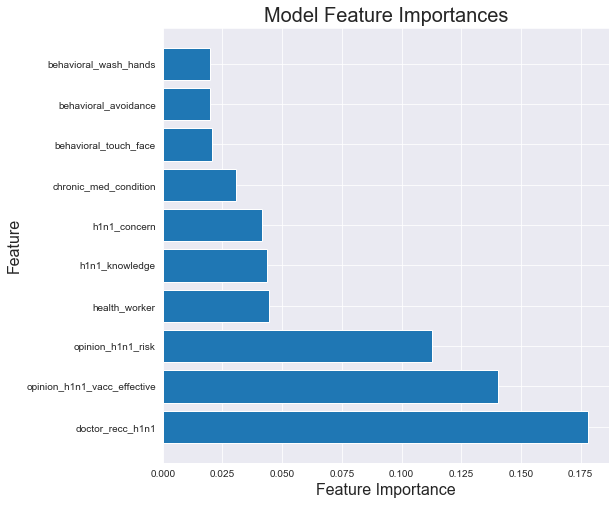

In [224]:
plot_feature_importance(forest_3)

## XG Boost

In [225]:
boost = XGBClassifier(random_state=42)
boost.fit(X_train_resampled, y_train_resampled)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=0, num_parallel_tree=1, random_state=42,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [226]:
print('XG Boost Model Training Scores: \n',
     classification_report(y_train_resampled, boost.predict(X_train_resampled)))
print('XG Boost Model Test Scores: \n',
     classification_report(y_test, boost.predict(X_test_final)))

XG Boost Model Training Scores: 
               precision    recall  f1-score   support

           0       0.91      0.97      0.94     14615
           1       0.97      0.90      0.94     14615

    accuracy                           0.94     29230
   macro avg       0.94      0.94      0.94     29230
weighted avg       0.94      0.94      0.94     29230

XG Boost Model Test Scores: 
               precision    recall  f1-score   support

           0       0.87      0.93      0.90      4898
           1       0.64      0.48      0.55      1309

    accuracy                           0.83      6207
   macro avg       0.75      0.70      0.72      6207
weighted avg       0.82      0.83      0.82      6207



In [227]:
boost_param_grid = {'learning_rate' : [.1, .2, .3],
                   'max_depth' : [4, 5, 6],
                   'min_child_weight' : [.5, .7, 1],
                   'n_estimators' : [100, 150, 200]}

gs_boost = GridSearchCV(boost, boost_param_grid, cv=3)
gs_boost.fit(X_train_resampled, y_train_resampled)

GridSearchCV(cv=3,
             estimator=XGBClassifier(base_score=0.5, booster='gbtree',
                                     colsample_bylevel=1, colsample_bynode=1,
                                     colsample_bytree=1, gamma=0, gpu_id=-1,
                                     importance_type='gain',
                                     interaction_constraints='',
                                     learning_rate=0.300000012,
                                     max_delta_step=0, max_depth=6,
                                     min_child_weight=1, missing=nan,
                                     monotone_constraints='()',
                                     n_estimators=100, n_jobs=0,
                                     num_parallel_tree=1, random_state=42,
                                     reg_alpha=0, reg_lambda=1,
                                     scale_pos_weight=1, subsample=1,
                                     tree_method='exact', validate_parameters=1,
        

In [228]:
gs_boost.best_params_

{'learning_rate': 0.1,
 'max_depth': 5,
 'min_child_weight': 0.5,
 'n_estimators': 100}

In [229]:
boost_2 = XGBClassifier(random_state=42, 
                            learning_rate=.1, 
                            max_depth = 5, 
                            min_child_weight = .5, 
                            n_estimators = 100)
boost_2.fit(X_train_resampled, y_train_resampled)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.1, max_delta_step=0, max_depth=5,
              min_child_weight=0.5, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=0, num_parallel_tree=1, random_state=42,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [230]:
print('XG Boost Model Training Scores: \n',
     classification_report(y_train_resampled, boost.predict(X_train_resampled)))
print('XG Boost Model Test Scores: \n',
     classification_report(y_test, boost.predict(X_test_final)))
print('Second XG Boost Model Training Scores: \n',
     classification_report(y_train_resampled, boost_2.predict(X_train_resampled)))
print('Second XG Boost Model Test Scores: \n',
     classification_report(y_test, boost_2.predict(X_test_final)))

Second XG Boost Model Training Scores: 
               precision    recall  f1-score   support

           0       0.87      0.94      0.91     14615
           1       0.94      0.86      0.90     14615

    accuracy                           0.90     29230
   macro avg       0.91      0.90      0.90     29230
weighted avg       0.91      0.90      0.90     29230

Second XG Boost Model Test Scores: 
               precision    recall  f1-score   support

           0       0.87      0.93      0.90      4898
           1       0.66      0.48      0.56      1309

    accuracy                           0.84      6207
   macro avg       0.76      0.71      0.73      6207
weighted avg       0.83      0.84      0.83      6207



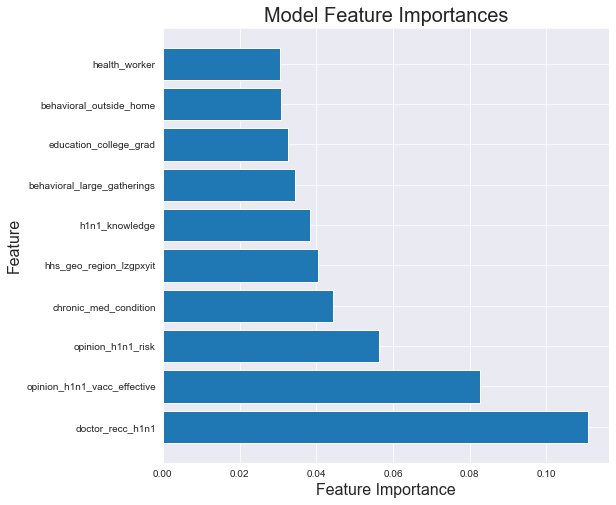

In [231]:
plot_feature_importance(boost_2)